# Import Modules

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import json
import sentencepiece as spm
from typing import Tuple, Dict

# Load the fine tuning data set

In [2]:
file_path = "/kaggle/input/finetunedataset/fine_tuning.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# Load the Tokenizer

In [3]:
sp = spm.SentencePieceProcessor()
sp.load("/kaggle/input/bpe-tokenizer/model_bpe.model")

True

# Hyperparameters

In [4]:
# Set a random seed
torch.manual_seed(1337)
# How many independent sequences will we process in parallel?
batch_size = 64
# What is the maximum context length for prediction?
block_size = 128
# How many iterations we will be doing in our training loop
max_iters = 50
# The interval in which we want to calculate the loss. We cannot do that after each step
eval_interval = 10
# The learning rate of the model
learning_rate = 1e-4
# Use GPU to train the model. If GPU is not existed, use the CPU instead.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Number of Embedding dimensions
n_embd = 384
# Number of Heads
n_head = 6
# Number of Block Layers
n_layer = 6
# Dropout
dropout = 0.2

In [5]:
vocab_size = sp.get_piece_size()

# Tokenize the fine tuning data

In [6]:
tokenized_data = []
for item in data:
    tokenized_item = sp.encode_as_ids(item)
    tokenized_data.append(tokenized_item)

In [7]:
split_index = int(0.9*len(tokenized_data))
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

# Trim and pad the data

In [8]:
def trim_data(data: list[list[int]], block_size: int) -> list[list[int]]:
    trimed_data = []
    for i in range(len(data)):
        item = data[i]
        if len(item) > block_size:
            item = item[-block_size:]
        trimed_data.append(item)
    return trimed_data

In [9]:
trimed_train_data = trim_data(train_data, block_size)
trimed_val_data = trim_data(val_data, block_size)

In [10]:
padding_token = sp.piece_to_id("<pad>")
ending_token = sp.piece_to_id("</answer>")

In [11]:
def apply_padding(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input = tensor,
            pad = (0, block_size - len(tensor)),
            value = padding_token
        )
        tensors.append(padded_tensor)
    return torch.stack(tensors)

In [12]:
train_data_tensor = apply_padding(trimed_train_data, block_size, padding_token)
val_data_tensor = apply_padding(trimed_val_data, block_size, padding_token)

# Data loader

In [13]:
class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y

In [14]:
def get_dataloaders(
    train_data: torch.Tensor,
    val_data: torch.Tensor,
    device: torch.device,
    padding_token: int
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = FineTuningDataset(
        data = train_data,
        device = device,
        padding_token = padding_token
    )
    val_dataset = FineTuningDataset(
        data = val_data, 
        device = device,
        padding_token = padding_token
    )
    train_loader = DataLoader(
        train_dataset, 
        batch_size = batch_size,
        shuffle = True,
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size = batch_size,
        shuffle = False,
    )
    return train_loader, val_loader

# Model

I copy codes from previous notebook.

In [15]:
class Head(nn.Module):
    '''A class that represents a single SA head'''

    def __init__(self, n_embd: int, head_size: int, block_size: int, dropout: float) -> None:
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v=self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
  '''multiple heads of self-attention in parallel'''

  def __init__(self, n_embd: int, num_heads: int, head_size: int, block_size: int, dropout: float) -> None:
    super().__init__()
    self.heads = nn.ModuleList([
        Head(n_embd, head_size, block_size, dropout) for _ in range(num_heads)
    ])
    self.proj = nn.Linear(head_size*num_heads, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

class FeedForward(nn.Module):
  '''a linear layer followed by a non-linearity'''
  def __init__(self, n_embd: int, dropout: float) -> None:
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.net(x)

class Block(nn.Module):
  '''A Transformer block: communication followed by computation'''
  def __init__(self, n_embd: int, n_head: int, block_size: int, dropout: float) -> None:
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(
        n_embd = n_embd,
        num_heads = n_head,
        head_size = head_size,
        block_size = block_size,
        dropout = dropout
    )
    self.ffwd = FeedForward(n_embd, dropout)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

class GPTLanguageModel(nn.Module):

    def __init__(
        self, 
        vocab_size: int,
        n_embd: int,
        n_head: int,
        block_size: int,
        n_layer: int,
        dropout: float,
        device: str,
        ignore_index: int = -100
    ) -> None:
        print("Created the GPTLanguageModel")
        super().__init__()
        self.ignore_index = ignore_index
        self.block_size = block_size
        self.device = device
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[
            Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size) # Language model head
        self.apply(self.init_weights)
        self.to(device)

    def init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    # This is not a feed forward layer, but gets us the next logits we need for the generate method
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)

        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=self.ignore_index)

        return logits, loss

    # A method that will generate the next token in our timeline. So like:
    # "A ca" -> "A cat" -> "A cat " -> ...
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            # Get the current predictions. This "self" call will automatically call
            # our "forward" method above
            logits, loss = self(idx_cond)
            # focus only on the last time step (token)
            logits = logits[:, - 1, :]
            # Do a softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # Sample from the prob distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append the next probable index (=token) to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [16]:
model = GPTLanguageModel(
    vocab_size = vocab_size,
    block_size = block_size,
    n_embd = n_embd,
    n_head = n_head,
    n_layer = n_layer,
    dropout = dropout,
    device = device,
    ignore_index = padding_token
).to(device)
model = torch.compile(model)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

Created the GPTLanguageModel
12.996792 M parameters


In [17]:
checkpoint_path = "/kaggle/input/pretrained-gpt-model/pytorch/default/4/checkpoint-all-compile.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

# Training

In [18]:
@torch.no_grad()
def estimate_loss(
    model: nn.Module, 
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    out = {}
    model.eval()
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                logits, loss = model(x, y)
                losses.append(loss.item())
        out[split] = sum(losses) / len(losses)
    model.train()
    return out

In [19]:
def save_checkpoint(
  model: GPTLanguageModel,
  optimizer: torch.optim.Optimizer,
  epoch: int,
  loss: float,
  path: str = "checkpoint-finetuning.pth"
) -> None:
  checkpoint = {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss
  }
  torch.save(checkpoint, path)

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loader, val_loader = get_dataloaders(
    train_data=train_data_tensor,
    val_data=val_data_tensor,
    device=device,
    padding_token = padding_token
)

In [21]:
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader)-1:
            losses = estimate_loss(
                model = model,
                train_loader = train_loader,
                val_loader = val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(f"iteration {iteration} / step {batch_idx}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if iteration+1 == max_iters:
        save_checkpoint(model, optimizer, iteration, loss.item())

W0601 00:15:29.003000 35 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


iteration 0 / step 0: train loss 10.3097, val loss 10.1835
iteration 0 / step 10: train loss 5.6750, val loss 5.7307
iteration 0 / step 14: train loss 5.3634, val loss 5.3976
iteration 1 / step 0: train loss 5.2817, val loss 5.3283
iteration 1 / step 10: train loss 4.4815, val loss 4.5705
iteration 1 / step 14: train loss 4.2097, val loss 4.3608
iteration 2 / step 0: train loss 4.1770, val loss 4.3310
iteration 2 / step 10: train loss 3.9079, val loss 4.1367
iteration 2 / step 14: train loss 3.8190, val loss 4.0757
iteration 3 / step 0: train loss 3.8080, val loss 4.0639
iteration 3 / step 10: train loss 3.6631, val loss 3.9933
iteration 3 / step 14: train loss 3.5689, val loss 3.9528
iteration 4 / step 0: train loss 3.5911, val loss 3.9439
iteration 4 / step 10: train loss 3.4378, val loss 3.8945
iteration 4 / step 14: train loss 3.3623, val loss 3.8812
iteration 5 / step 0: train loss 3.3949, val loss 3.8750
iteration 5 / step 10: train loss 3.2532, val loss 3.8504
iteration 5 / step

# Check the result

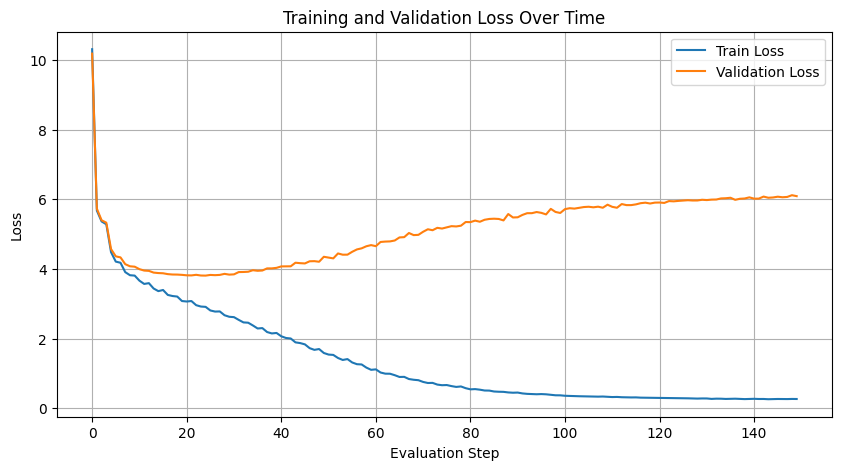

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [23]:
def generate_answer(prompt: str, max_new_tokens: int):
    input_tokens = sp.encode_as_ids(f"<question>{prompt}</question><answer>")
    input_tokens = torch.tensor(input_tokens, dtype=torch.long, device=device).unsqueeze(0)
    model_answer = ""
    model.eval()
    while True:
        output_tokens = model.generate(input_tokens, max_new_tokens=max_new_tokens)
        last_generated_token = output_tokens[0, -1].item()
        if last_generated_token == ending_token:
            break
        input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
        model_answer += sp.decode_ids([last_generated_token])
        if len(output_tokens[0]) > block_size:
            input_tokens = input_tokens[:, -block_size:]
        
    return model_answer

In [24]:
# A general conversation
prompt1 = "How are you?"
# A question in the dataset
prompt2 = "What year was the song released?"
# A new question that does not appear in the dataset
prompt3 = "How many continents in the world?"

In [27]:
print("Answer 1: ", generate_answer(prompt1, max_new_tokens=2))
print("Answer 2: ", generate_answer(prompt2, max_new_tokens=2))
print("Answer 3: ", generate_answer(prompt3, max_new_tokens=2))

Answer 1:  nvot
Answer 2:  8
Answer 3:  3


# Closure

Here we get overfitting again. This behaviour is similar to the pretrain stage. To see the performance of the model, I input three questions to generate answers. 

The general conversation is not trained. The model only gives a non-sense answer. The second question is in the dataset, but it also gives a wrong answer. At least, it knows the answer should be a number. The third answer is also wrong, but it gives a number again. 

One can generate the answers several times. The first answer tends to be a non-sense word, the second answer tends to be a date (even though the spelling is strange), and the last one tends to be a number. 

To get a better performance, we need more data and computer power.